In [1]:
import pandas as pd
import numpy as np
import os as os
import aux.acessos as ac
import aux.aed as aed
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
dt_query = "2022-01-01"

In [3]:
query = f"""
with principal as (
	select 
	t.dt_dia
	, t.dt_mes
	, cast(substring(t.dt_dia, 9, 2) as double) as dia_mes
	, cast(substring(t.dt_dia, 1, 4) as double) as ano
	, t.cpf
	, max(t.vl_limite_cartao) as vl_limite_cartao 
	, sum(t.vl_transacao) as vl_spending
	, count(distinct id_autorizacao) as transacoes
	from platform_curated_zone.transaction_dedicada_spending t
	where cast(dt_dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	and cast(dt_dia as date) <= to_date('2023-03-30','yyyy-mm-dd')
	group by 1,2,3,4,5
)
, principal_add as (
select
t.cpf
	, max(c.ds_cluster_sociodemographic) as ds_cluster_sociodemographic 
	, max(ie.nr_score_ie) as nr_score_ie
    , max(g.nr_due_day) as dia_vencimento
from principal t
	left join customer_curated_zone.ca_book_cliente i on (i.cpf = t.cpf)
	left join customer_curated_zone.ca_book_cliente_cluster c on (c.id_customer = i.id_customer)
	left join customer_curated_zone.ca_model_ie_cliente ie on (ie.cd_cpf = t.cpf and ie.cd_yearmonth = cast(replace(t.dt_mes, '-') as double))
	inner join customer_curated_zone.ca_book_growth g on (g.id_customer = i.id_customer and g.dt_opening_account <= to_date('{dt_query}','yyyy-mm-dd'))
group by 1
)
, amostra_clientes as (
select * from 
(select distinct cpf as cpf
from principal)
order by rand()
limit 100000
)
select p.* 
, d.ds_cluster_sociodemographic
, d.nr_score_ie
from principal p
left join principal_add d on (p.cpf = d.cpf)
inner join amostra_clientes a on (a.cpf = p.cpf)
"""

In [5]:
#df = ac.df_athena('flavia-costa', query)

In [21]:
# safras = [0,1, 2, 3, 4,5,6,7,8,9]

# df = pd.DataFrame()
# for i in safras:
#      query = query + " where substring(p.cpf, 4, 1) = '" + str(i) + "'"
#      #print(query)
#      temp_pers = ac.df_athena_q('flavia-costa', query)
     
#      df = df.append(temp_pers) 

/tmp/ipykernel_725786/1627088737.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_pers)
Failed to execute query.
Traceback (most recent call last):
  File "/home/flavia.costa/.local/lib/python3.8/site-packages/pyathena/common.py", line 494, in _execute
    query_id = retry_api_call(
  File "/home/flavia.costa/.local/lib/python3.8/site-packages/pyathena/util.py", line 84, in retry_api_call
    return retry(func, *args, **kwargs)
  File "/home/flavia.costa/.local/lib/python3.8/site-packages/tenacity/__init__.py", line 404, in __call__
    do = self.iter(retry_state=retry_state)
  File "/home/flavia.costa/.local/lib/python3.8/site-packages/tenacity/__init__.py", line 349, in iter
    return fut.result()
  File "/usr/lib/python3.8/concurrent/futures/_base.py", line 437, in result
    return self.__get_result()
  File "/usr/lib/python3.8/concurrent/futures/_base.py", line 389, in 

DatabaseError: (pyathena.error.DatabaseError) An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 31:37: mismatched input 'where'. Expecting: '%', '*', '+', '-', '.', '/', 'AND', 'AT', 'EXCEPT', 'FETCH', 'GROUP', 'HAVING', 'INTERSECT', 'LIMIT', 'OFFSET', 'OR', 'ORDER', 'UNION', 'WINDOW', '[', '||', <EOF>
[SQL: 
with principal as (
	select 
	t.dt_dia
	, t.dt_mes
	, cast(substring(t.dt_dia, 9, 2) as double) as dia_mes
	, cast(substring(t.dt_dia, 1, 4) as double) as ano
	, t.cpf
	, max(c.ds_cluster_sociodemographic) as ds_cluster_sociodemographic 
	, max(ie.nr_score_ie) as nr_score_ie 
	, max(t.vl_limite_cartao) as vl_limite_cartao 
	, sum(vl_transacao) as vl_spending
	, count(distinct id_autorizacao) as transacoes
	from platform_curated_zone.transaction_dedicada_spending t
	left join customer_curated_zone.ca_book_cliente i on (i.cpf = t.cpf)
	left join customer_curated_zone.ca_book_cliente_cluster c on (c.id_customer = i.id_customer)
	left join customer_curated_zone.ca_model_ie_cliente ie on (ie.cd_cpf = t.cpf and ie.cd_yearmonth = cast(replace(t.dt_mes, '-') as double))
	inner join customer_curated_zone.ca_book_growth g on (g.id_customer = i.id_customer and g.dt_opening_account <= to_date('2022-01-01','yyyy-mm-dd'))
	where cast(dt_dia as date) >= to_date('2022-01-01','yyyy-mm-dd')
	and cast(dt_dia as date) <= to_date('2023-03-30','yyyy-mm-dd')
	group by 1,2,3,4,5
)
, amostra_clientes as (
select * from 
(select distinct cpf as cpf
from principal)
order by rand()
limit 100000
)
select p.* from principal p
inner join amostra_clientes a on (a.cpf = p.cpf)
 where substring(p.cpf, 4, 1) = '0' where substring(p.cpf, 4, 1) = '1']
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [17]:
#df.to_pickle('estudo_spending.pkl')

In [18]:
len(df)

3233476

## Dia do vencimento

In [7]:
query_dia_pgt = f"""
with principal as (
	select 
	t.dt_dia
	, t.dt_mes
	, cast(substring(t.dt_dia, 9, 2) as double) as dia_mes
	, cast(substring(t.dt_dia, 1, 4) as double) as ano
	, t.cpf
	, max(t.vl_limite_cartao) as vl_limite_cartao 
	, sum(t.vl_transacao) as vl_spending
	, count(distinct id_autorizacao) as transacoes
	from platform_curated_zone.transaction_dedicada_spending t
	where cast(dt_dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	and cast(dt_dia as date) <= to_date('2023-03-30','yyyy-mm-dd')
	group by 1,2,3,4,5
)
select
t.cpf
, max(g.nr_due_day) as dia_vencimento
from principal t
	left join customer_curated_zone.ca_book_cliente i on (i.cpf = t.cpf)
	inner join customer_curated_zone.ca_book_growth g on (g.id_customer = i.id_customer and g.dt_opening_account <= to_date('{dt_query}','yyyy-mm-dd'))
group by 1

"""

In [8]:
info_pag = ac.df_athena('flavia-costa', query_dia_pgt)

In [9]:
df = pd.read_pickle('estudo_spending.pkl')

In [11]:
len(df)

3233476

In [13]:
df = df.join(info_pag.set_index('cpf'), how = "left", on = 'cpf')

In [14]:
df.head()

,dt_dia,dt_mes,dia_mes,ano,cpf,vl_limite_cartao,vl_spending,transacoes,ds_cluster_sociodemographic,nr_score_ie,dia_vencimento
0,2022-01-23,2022-01,23.0,2022.0,70348829671,650.0,21.00,2,None,NaN,NaN
1,2023-03-17,2023-03,17.0,2023.0,06394297348,900.0,14.86,3,None,NaN,NaN
2,2023-01-11,2023-01,11.0,2023.0,44677003823,880.0,165.86,6,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",69.882660,25.0
3,2023-03-27,2023-03,27.0,2023.0,01765958482,2000.0,65.36,1,None,NaN,NaN
4,2022-08-10,2022-08,10.0,2022.0,10823790932,4100.0,47.00,2,"18 - Mulher, 25 a 40 anos, Sudeste e Sul",64.680574,25.0


In [15]:
df['fx_ie'] = np.where(df['nr_score_ie'] <= 20, '1 - ate 20%',
                             np.where(df['nr_score_ie'] <= 40, '2 - 20-40%',
                                      np.where(df['nr_score_ie'] <= 50, '3 - 40-50%',
                                               np.where(df['nr_score_ie'] <= 60, '4 - 50-60%',
                                                        np.where(df['nr_score_ie'] <= 70, '5 - 60-70%',
                                                                 np.where(df['nr_score_ie'] <= 80, '6 - 70-80%', '7 - >80%'))))))

In [16]:
df['fx_limite'] = np.where(df['vl_limite_cartao'] <= 500, '1 - ate R$500',
                             np.where(df['vl_limite_cartao'] <= 1000, '2 - R$500-1000',
                                      np.where(df['vl_limite_cartao'] <= 1500, '3 - R$1000-1500',
                                               np.where(df['vl_limite_cartao'] <= 2000, '4 - R$1500-2000',
                                                        np.where(df['vl_limite_cartao'] <= 3000, '5 - R$2000-3000',
                                                                 np.where(df['vl_limite_cartao'] <= 4000, '6 - R$3000-4000',
                                                                          np.where(df['vl_limite_cartao'] <= 5000, '7 - R$4000-5000', '8 - Mais de R$5000')))))))

In [34]:
df.describe()

,dia_mes,ano,vl_limite_cartao,vl_spending,transacoes,nr_score_ie
count,3.233476e+06,3.233476e+06,3.142473e+06,3.233476e+06,3.233476e+06,2.095812e+06
mean,1.589131e+01,2.022241e+03,3.175415e+03,1.696452e+02,1.588585e+00,6.083292e+01
std,8.510783e+00,4.279430e-01,3.943423e+03,4.157594e+02,1.095476e+00,2.467296e+01
min,1.000000e+00,2.022000e+03,0.000000e+00,-1.421900e+04,1.000000e+00,0.000000e+00
25%,9.000000e+00,2.022000e+03,7.000000e+02,2.420000e+01,1.000000e+00,5.636245e+01
50%,1.600000e+01,2.022000e+03,1.700000e+03,5.700000e+01,1.000000e+00,6.779661e+01
75%,2.300000e+01,2.022000e+03,3.800000e+03,1.500000e+02,2.000000e+00,7.607127e+01
max,3.100000e+01,2.023000e+03,3.000000e+04,3.342478e+04,1.240000e+02,9.846154e+01


In [26]:
#Calcular valor de Outlier
import aux.aed as aed

aed.valid(df, ['dt_dia','dt_mes','dia_mes','ano','cpf','ds_cluster_sociodemographic'])

tamanho do dataset:
3233476
valores nulos:
dt_dia                               0
dt_mes                               0
dia_mes                              0
ano                                  0
cpf                                  0
vl_limite_cartao                 91003
vl_spending                          0
transacoes                           0
ds_cluster_sociodemographic    1139696
nr_score_ie                    1137664
fx_ie                                0
fx_limite                            0
dtype: int64
valores distintos das variaveis categoricas:
fx_ie
7
fx_limite
8
____________________________
vl_limite_cartao
mínimo:
0.0
máximo:
30000.0
media:
3175.415146287653
mediana:
1700.0
coeficiente de variação:
124.18604714468802
coeficiente de assimetria de pearson:
1.1224375227504153
assimétrica positiva - concentração em valores menores
quantidade de outliers:
314583
quantidade de outliers percentual:
9.73
____________________________
vl_spending
mínimo:
-14219.0
máximo:
334

In [17]:
df2 = df.query('vl_spending > 0').query('vl_limite_cartao > 0')

df2 = aed.tira_outlier(df2, ['vl_spending'])

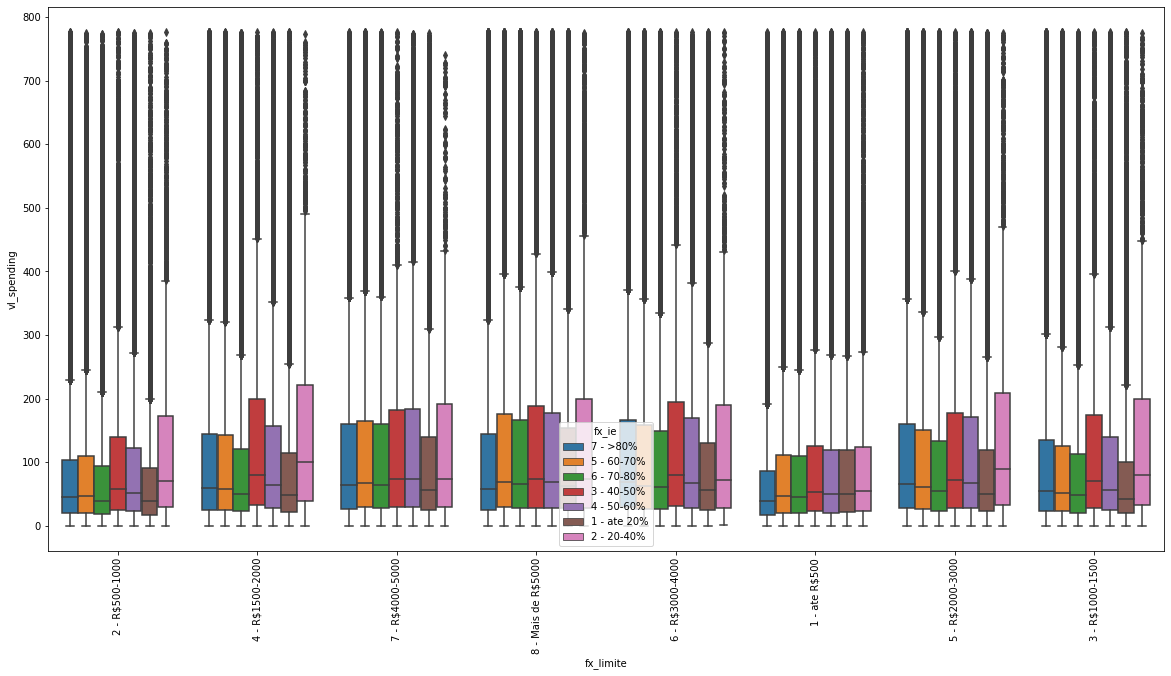

In [36]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df2, y = 'vl_spending', x = 'fx_limite', hue='fx_ie') 
plt.xticks(rotation=90)
plt.show()

In [25]:
df2['fx_limite'].value_counts()

8 - Mais de R$5000    533980
2 - R$500-1000        511424
1 - ate R$500         393203
5 - R$2000-3000       388710
3 - R$1000-1500       340002
4 - R$1500-2000       255278
6 - R$3000-4000       229802
7 - R$4000-5000       132500
Name: fx_limite, dtype: int64

In [43]:
df2['fx_ie'].value_counts()

7 - >80%       1422729
6 - 70-80%      556701
5 - 60-70%      491968
4 - 50-60%      265157
1 - ate 20%     228628
3 - 40-50%       90937
2 - 20-40%       33005
Name: fx_ie, dtype: int64

In [18]:
ord_lim = ['1 - ate R$500',
'2 - R$500-1000',
'3 - R$1000-1500',
'4 - R$1500-2000',
'5 - R$2000-3000',     
'6 - R$3000-4000',     
'7 - R$4000-5000',
'8 - Mais de R$5000']

In [19]:
ord_ie = ['1 - ate 20%',
'2 - 20-40%',
'3 - 40-50%' ,
'4 - 50-60%' ,
'5 - 60-70%' ,
'6 - 70-80%' ,
'7 - >80%' 
]

## Análise diária

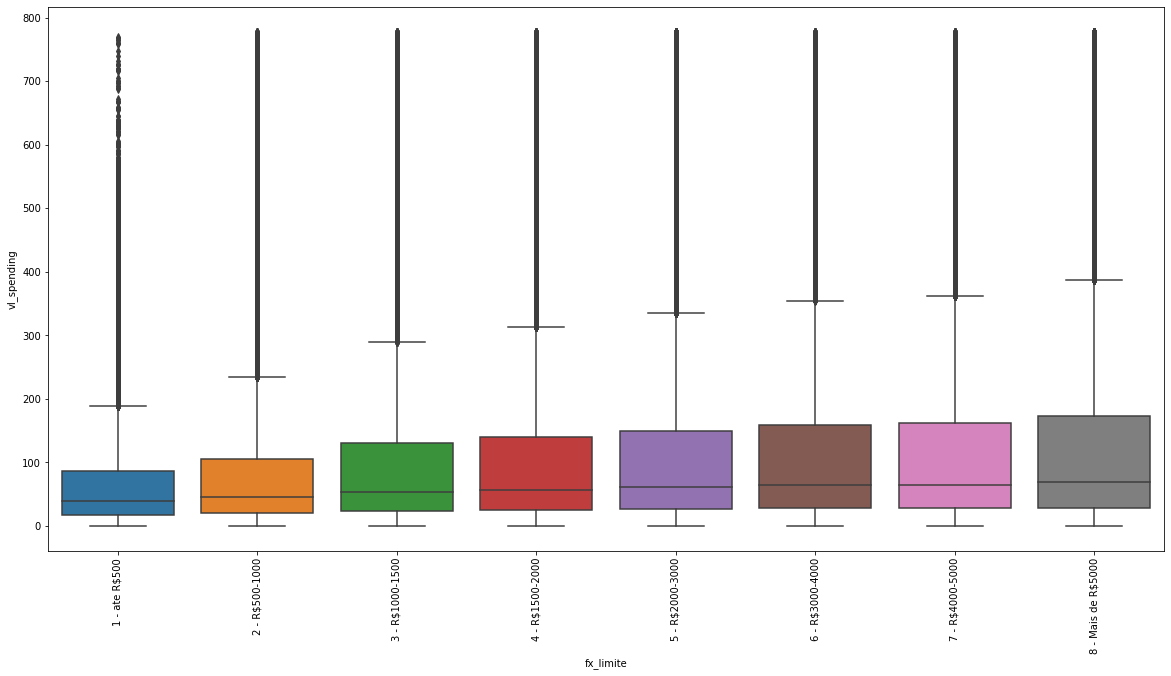

In [26]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df2, y = 'vl_spending', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

#### Conclusões:
- Para os gastos diários não há muita diferença entre as faixa de limite
- O P75 de todas as faixas é próximo de R$ 100, ou seja, 75% da base compra menos de R$ 100

### Dando um zoom - retirando acima de R$ 200

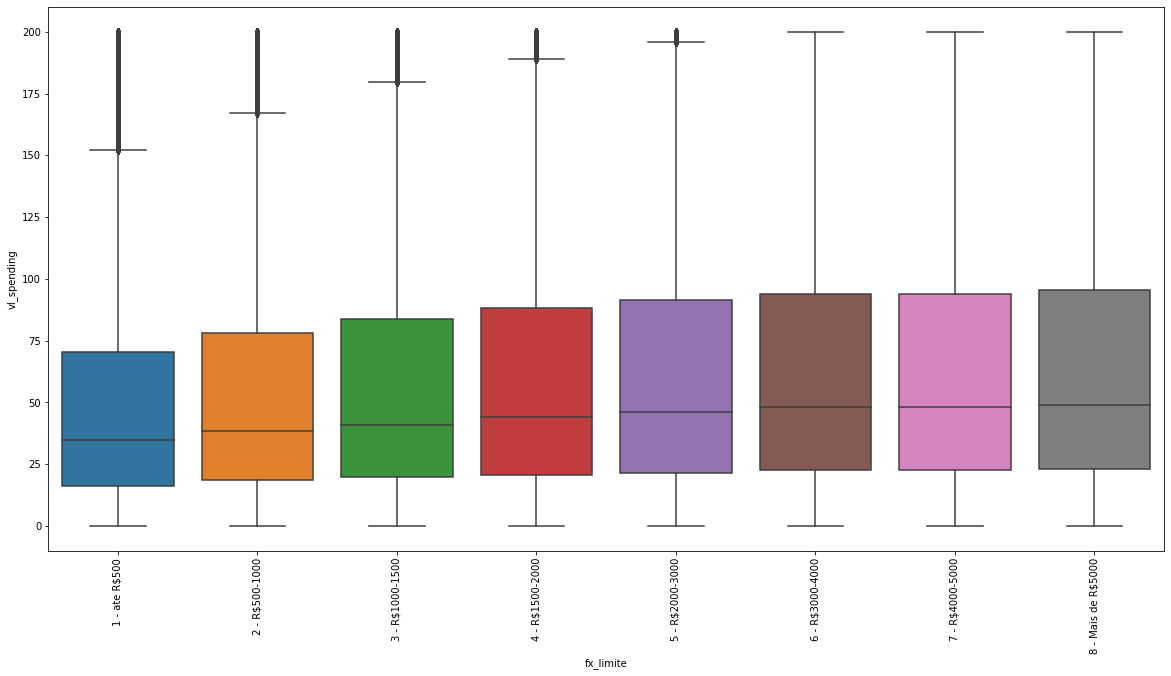

In [27]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df2.query('vl_spending < 200'), y = 'vl_spending', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

- P75 de R$ 75 a R$ 80

### Acima de R$ 200 por IE

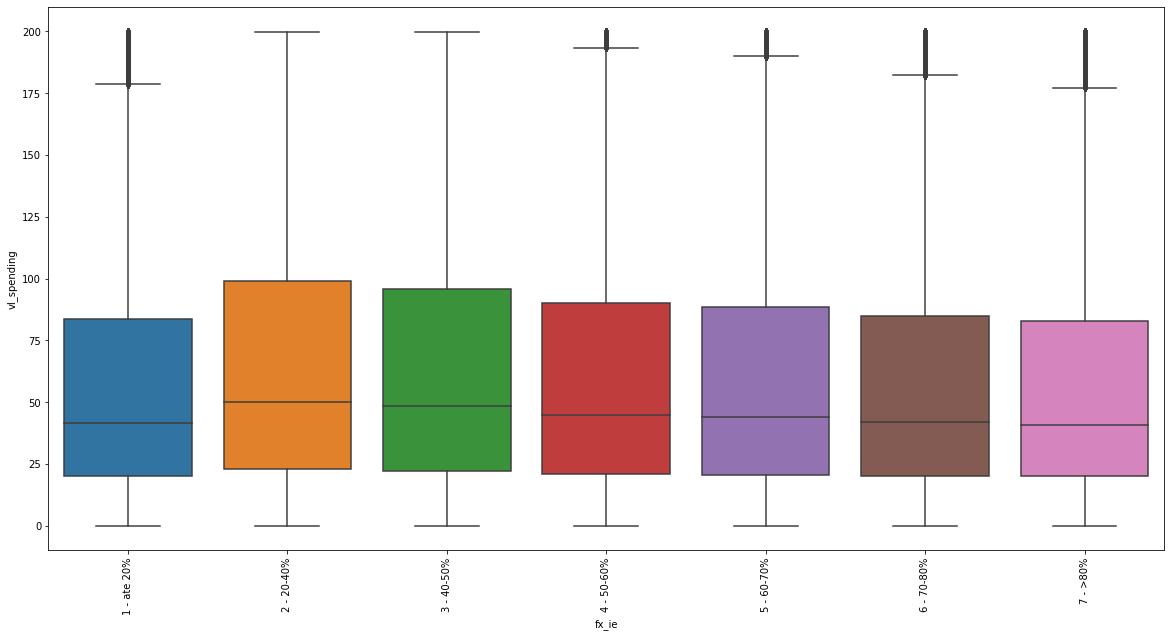

In [28]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df2.query('vl_spending < 200'), y = 'vl_spending', x = 'fx_ie', order=ord_ie) 
plt.xticks(rotation=90)
plt.show()

- Por IE não segue uma linearidade dos gastos

## Análise quinzenal

In [20]:
df2['quinz'] = np.where(df2.dia_mes <= 15, 1, 2)

In [21]:
df2['quinz'].value_counts()

2    1447710
1    1337189
Name: quinz, dtype: int64

In [22]:
df_quizenal = df2.groupby(['cpf','quinz','dt_mes' , 'fx_ie', 'fx_limite', 'dia_vencimento']).agg({'vl_spending':['sum'], 'transacoes':['sum']})
df_quizenal.columns = df_quizenal.columns.droplevel(0)
df_quizenal = df_quizenal.reset_index()
df_quizenal.columns = ['cpf','quinz','dt_mes', 'fx_ie','fx_limite','dia_vencimento','vl_spending','transacoes']
df_quizenal.head()

,cpf,quinz,dt_mes,fx_ie,fx_limite,dia_vencimento,vl_spending,transacoes
0,00001381342,1,2022-01,5 - 60-70%,8 - Mais de R$5000,25.0,344.44,1
1,00001381342,1,2022-02,5 - 60-70%,8 - Mais de R$5000,25.0,646.43,4
2,00001381342,1,2022-03,5 - 60-70%,8 - Mais de R$5000,25.0,347.25,2
3,00001381342,1,2022-05,5 - 60-70%,8 - Mais de R$5000,25.0,749.00,1
4,00001381342,1,2022-08,5 - 60-70%,8 - Mais de R$5000,25.0,220.00,2


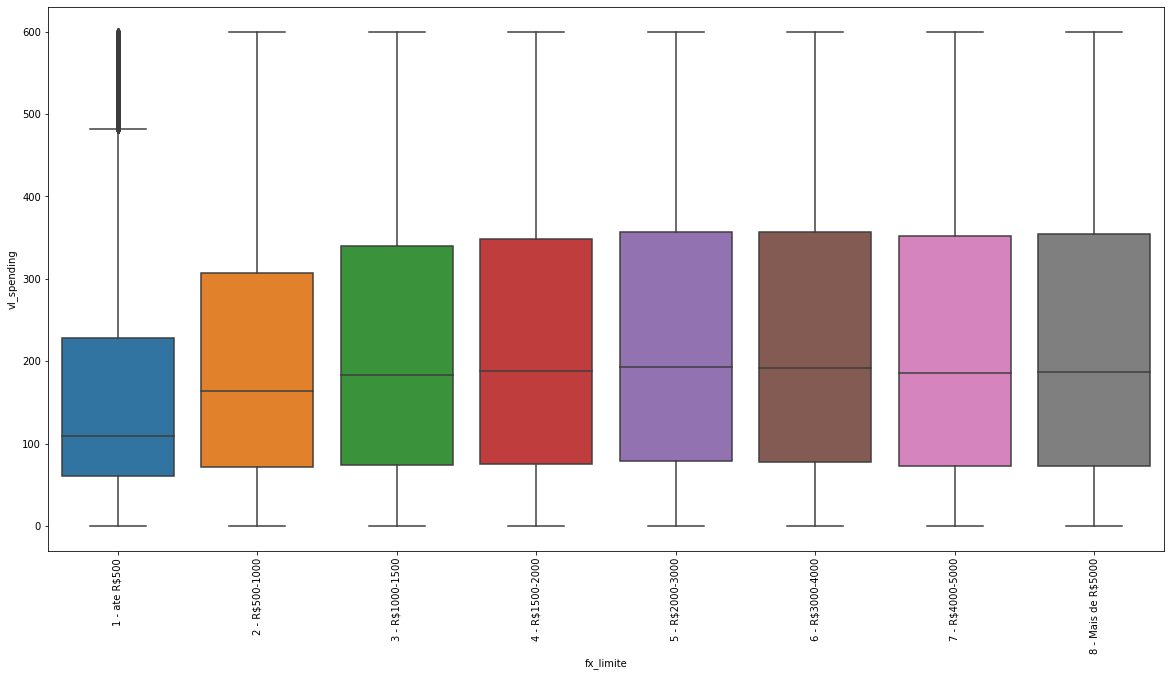

In [31]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'vl_spending', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

- Na quinzena conseguimos ver uma distinção maior de gastos entre faixas de limite
- para a faixa de menor limite o gasto não vai passar de 220 (P75 = 75% dos clientes com menos)

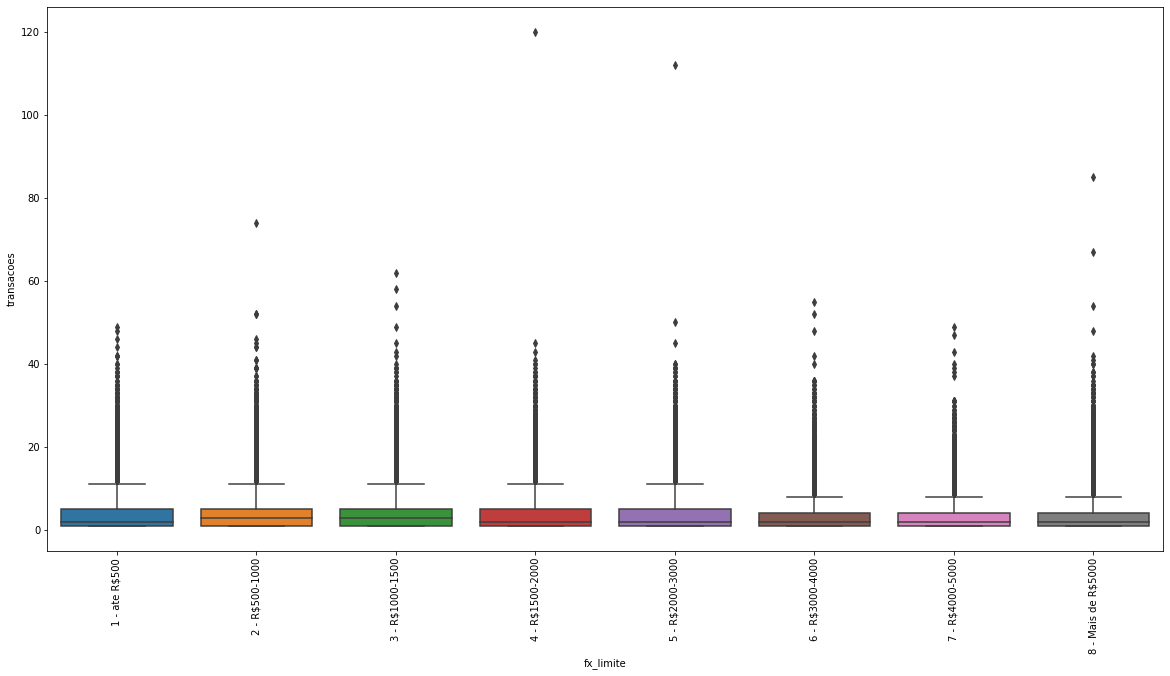

In [32]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'transacoes', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

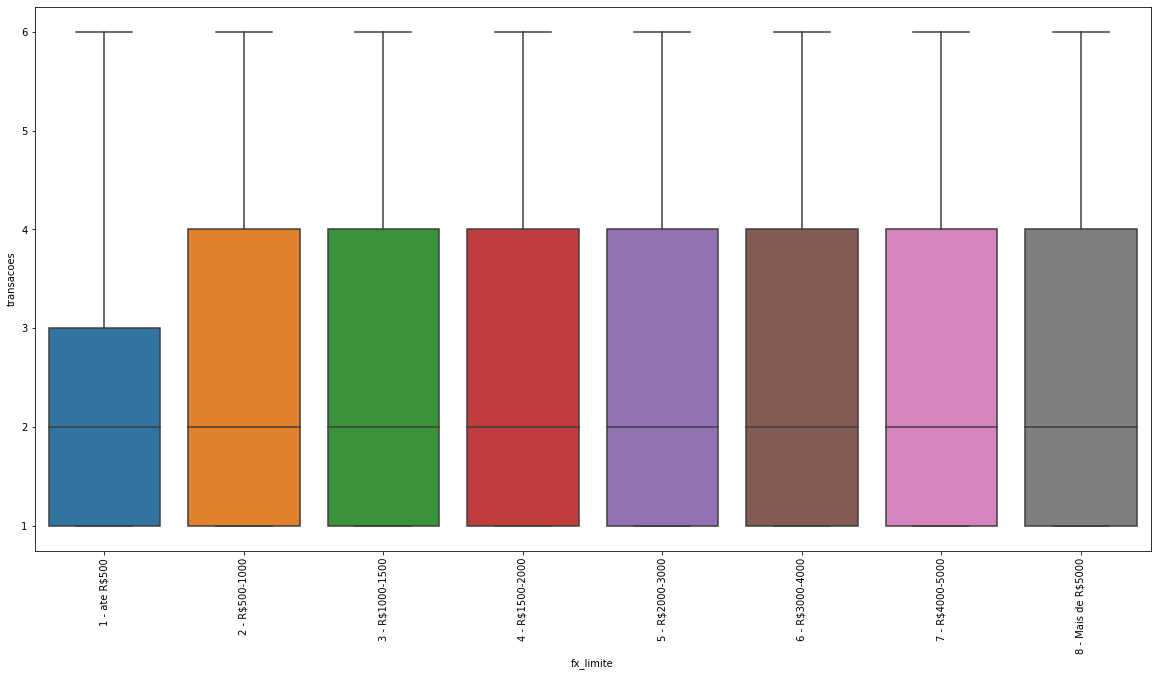

In [33]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('transacoes < 7'), y = 'transacoes', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

> <b> Na frequencia o p75 fica em 3x para o grupo de menor limite e 4x para os demais

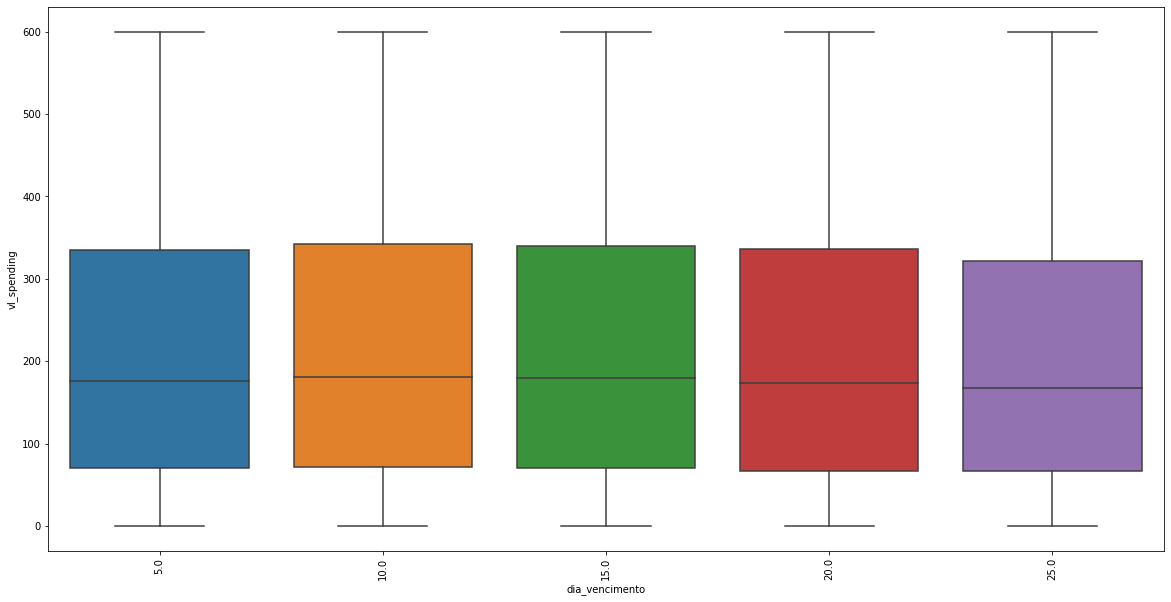

In [24]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'vl_spending', x = 'dia_vencimento') 
plt.xticks(rotation=90)
plt.show()

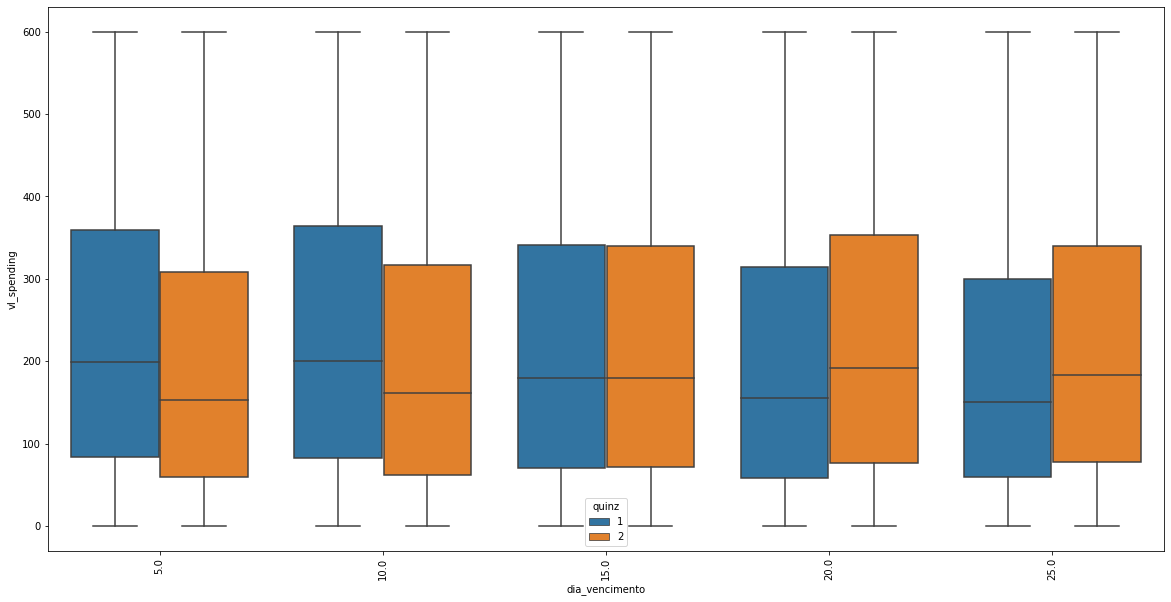

In [25]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'vl_spending', x = 'dia_vencimento', hue = 'quinz') 
plt.xticks(rotation=90)
plt.show()

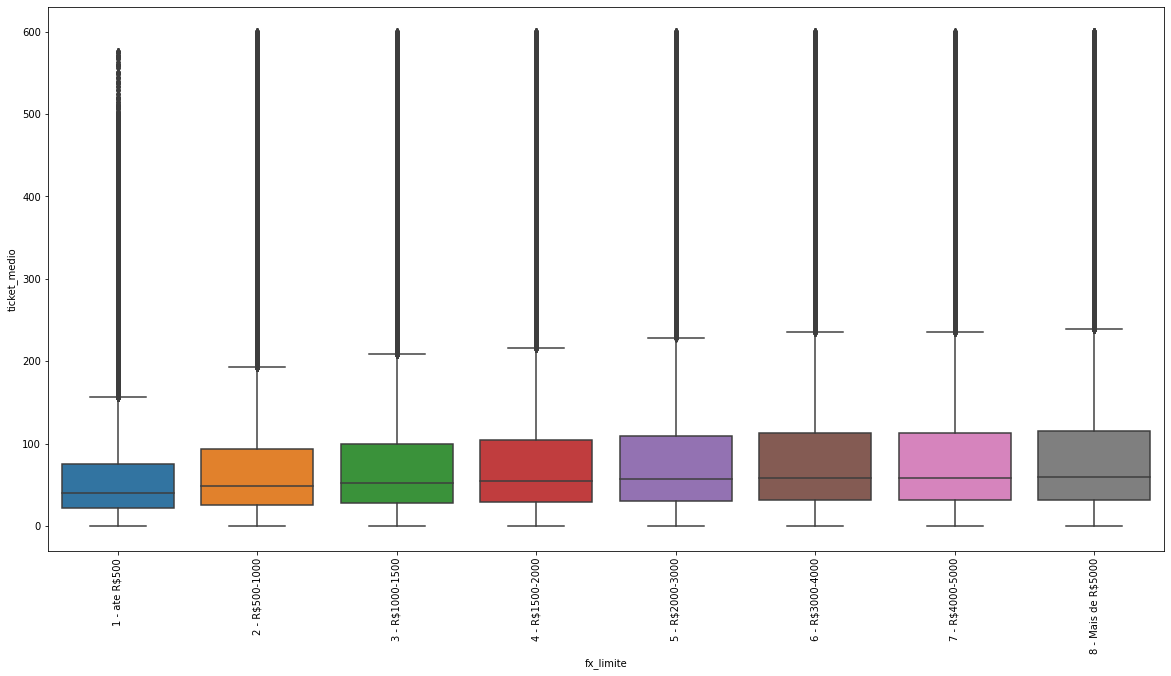

In [34]:
df_quizenal['ticket_medio'] = df_quizenal['vl_spending'] / df_quizenal['transacoes']

plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'ticket_medio', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

In [48]:
df_quizenal

,cpf,quinz,dt_mes,fx_ie,fx_limite,vl_spending,transacoes,ticket_medio
0,00001133527,1,2022-09,7 - >80%,2 - R$500-1000,99.67,5,19.934000
1,00001133527,1,2022-10,7 - >80%,2 - R$500-1000,108.00,3,36.000000
2,00001133527,1,2022-11,7 - >80%,2 - R$500-1000,247.43,7,35.347143
3,00001133527,1,2022-12,7 - >80%,2 - R$500-1000,380.00,1,380.000000
4,00001133527,2,2022-09,7 - >80%,2 - R$500-1000,174.64,4,43.660000
...,...,...,...,...,...,...,...,...
965077,99999285520,2,2022-05,7 - >80%,4 - R$1500-2000,358.35,1,358.350000
965078,99999285520,2,2022-07,7 - >80%,4 - R$1500-2000,235.82,9,26.202222
965079,99999285520,2,2022-10,7 - >80%,4 - R$1500-2000,173.00,1,173.000000
965080,99999285520,2,2022-11,7 - >80%,4 - R$1500-2000,225.45,5,45.090000


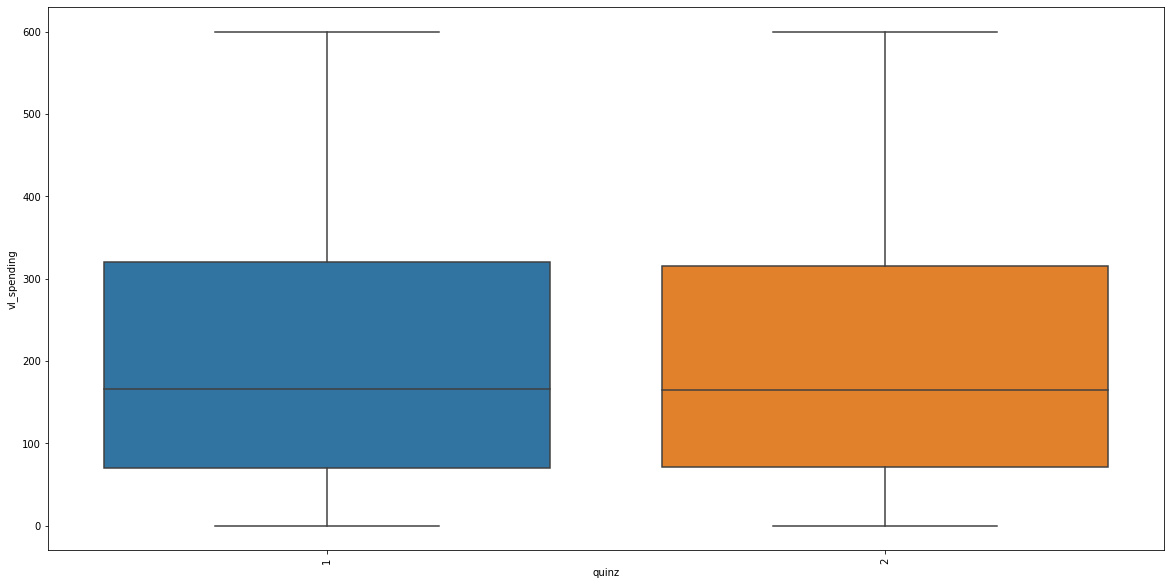

In [51]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'vl_spending', x = 'quinz') 
plt.xticks(rotation=90)
plt.show()

#### POR INDICE DE ENGAJAMENTO

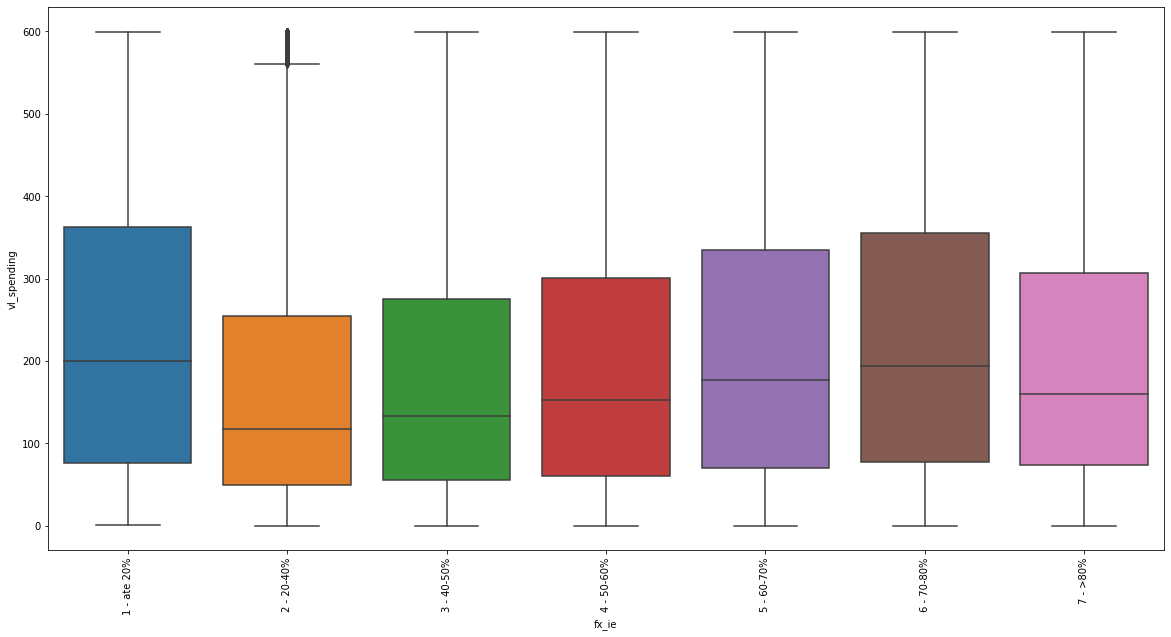

In [35]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('vl_spending < 600'), y = 'vl_spending', x = 'fx_ie', order=ord_ie) 
plt.xticks(rotation=90)
plt.show()

#### <b> Uma meta quinzenal de R$ 350 seria desejável do ponto de vista de engajamento, no potencial máximo (P75) , assim como o critério de maior limite

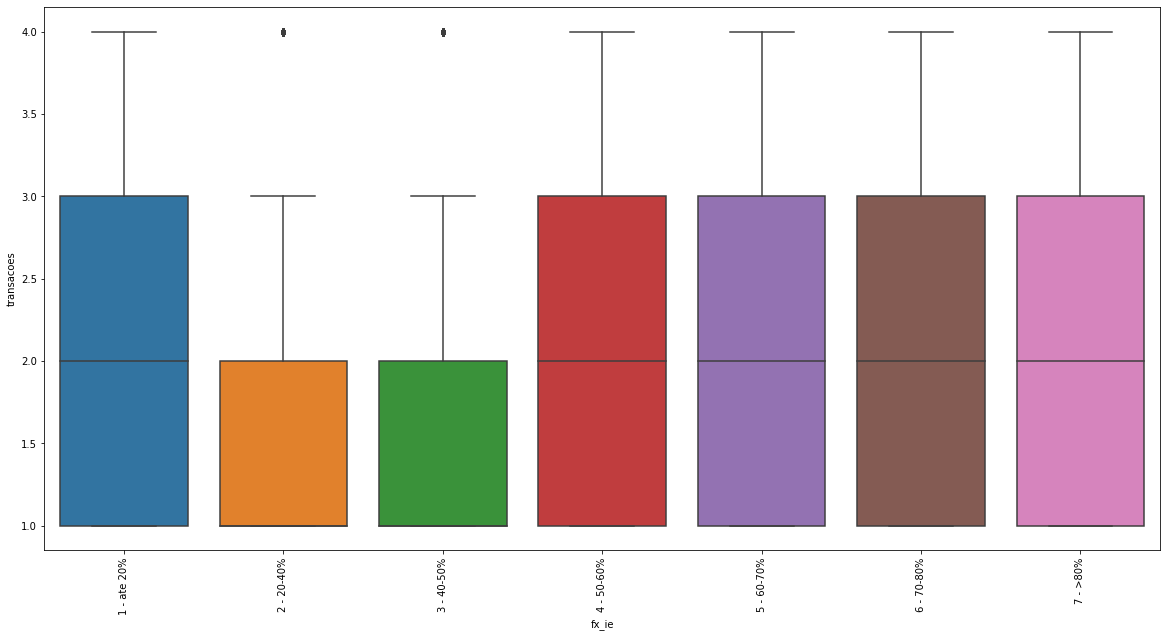

In [36]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_quizenal.query('transacoes < 5'), y = 'transacoes', x = 'fx_ie', order=ord_ie) 
plt.xticks(rotation=90)
plt.show()

## Análise Mensal

In [37]:
df_mensal = df2.groupby(['cpf','dt_mes', 'fx_ie', 'fx_limite', 'ds_cluster_sociodemographic']).agg({'vl_spending':['sum'], 'transacoes':['sum']})
df_mensal.columns = df_mensal.columns.droplevel(0)
df_mensal = df_mensal.reset_index()
df_mensal.columns = ['cpf','dt_mes','fx_ie','fx_limite','ds_cluster_sociodemographic', 'vl_spending','transacoes']
df_mensal.head()

,cpf,dt_mes,fx_ie,fx_limite,ds_cluster_sociodemographic,vl_spending,transacoes
0,00001381342,2022-01,5 - 60-70%,8 - Mais de R$5000,"19 - Mulher, 41 anos ou mais, Nordeste",369.34,2
1,00001381342,2022-02,5 - 60-70%,8 - Mais de R$5000,"19 - Mulher, 41 anos ou mais, Nordeste",1374.36,5
2,00001381342,2022-03,5 - 60-70%,8 - Mais de R$5000,"19 - Mulher, 41 anos ou mais, Nordeste",347.25,2
3,00001381342,2022-05,5 - 60-70%,8 - Mais de R$5000,"19 - Mulher, 41 anos ou mais, Nordeste",880.26,3
4,00001381342,2022-07,5 - 60-70%,8 - Mais de R$5000,"19 - Mulher, 41 anos ou mais, Nordeste",279.30,1


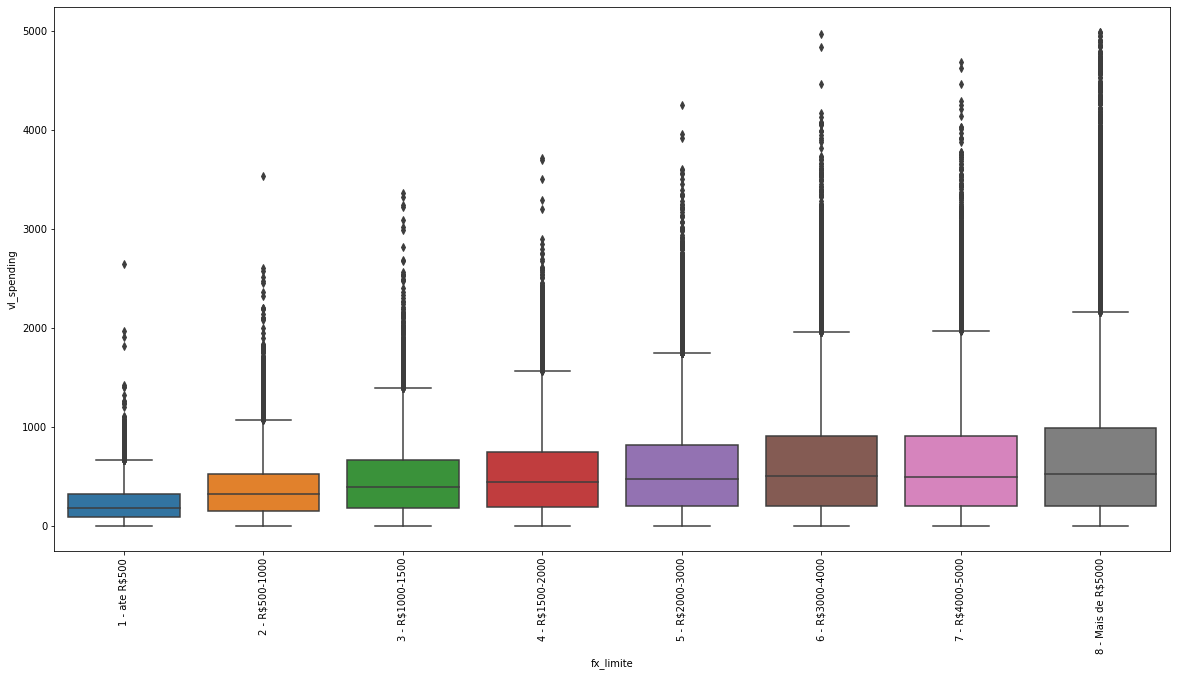

In [38]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_mensal.query('vl_spending < 5000'), y = 'vl_spending', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

#### Dando zoom no gasto mensal por limite

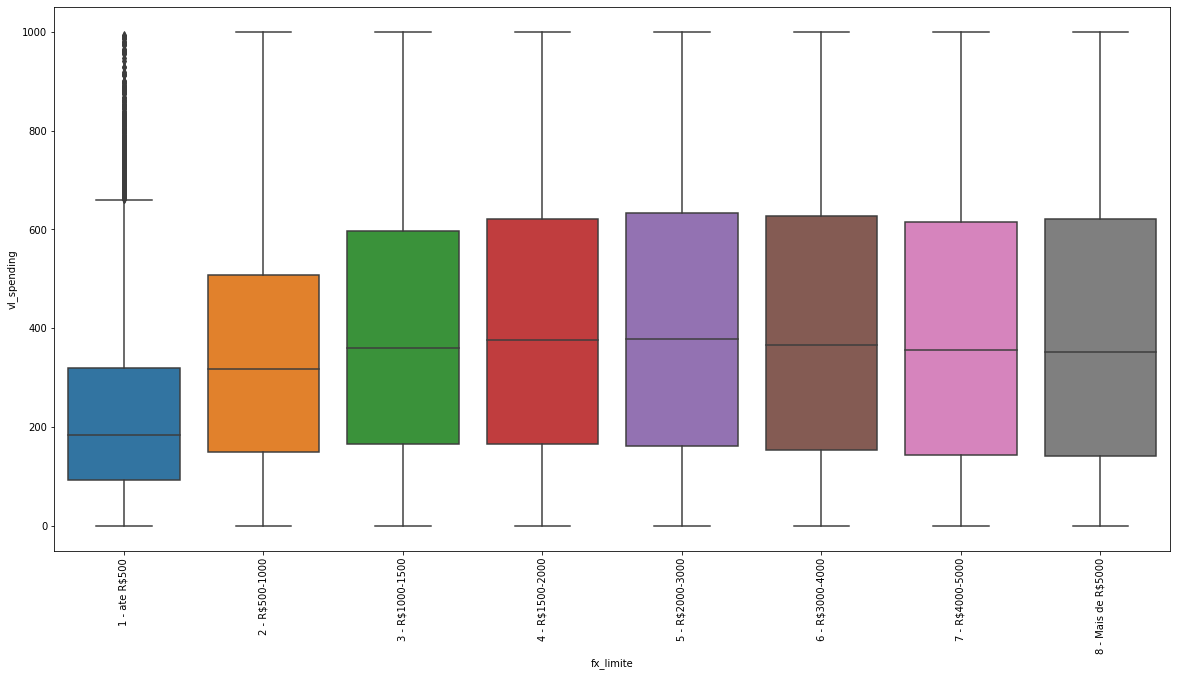

In [39]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_mensal.query('vl_spending < 1000'), y = 'vl_spending', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

In [40]:
len(df_mensal.query('fx_limite == "1 - ate R$500"').query('vl_spending > 500'))

1254

In [41]:
df_mensal.query('fx_limite == "1 - ate R$500"').query('vl_spending > 500')

,cpf,dt_mes,fx_ie,fx_limite,ds_cluster_sociodemographic,vl_spending,transacoes
271,00043170250,2022-01,7 - >80%,1 - ate R$500,"26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",563.09,9
272,00043170250,2022-02,7 - >80%,1 - ate R$500,"26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",544.55,8
1068,00136052592,2023-01,4 - 50-60%,1 - ate R$500,"19 - Mulher, 41 anos ou mais, Nordeste",569.93,8
1892,00229641180,2022-09,6 - 70-80%,1 - ate R$500,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",684.27,12
1894,00229641180,2022-11,6 - 70-80%,1 - ate R$500,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",543.16,15
...,...,...,...,...,...,...,...
367399,98624431204,2022-11,6 - 70-80%,1 - ate R$500,"26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",1044.11,21
367402,98624431204,2023-03,6 - 70-80%,1 - ate R$500,"26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",500.55,18
367696,98942913253,2022-06,4 - 50-60%,1 - ate R$500,"26 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",539.15,7
367707,98950118904,2022-11,2 - 20-40%,1 - ate R$500,"22 - Mulher, 41 anos ou mais, Sudeste e Sul",513.00,2


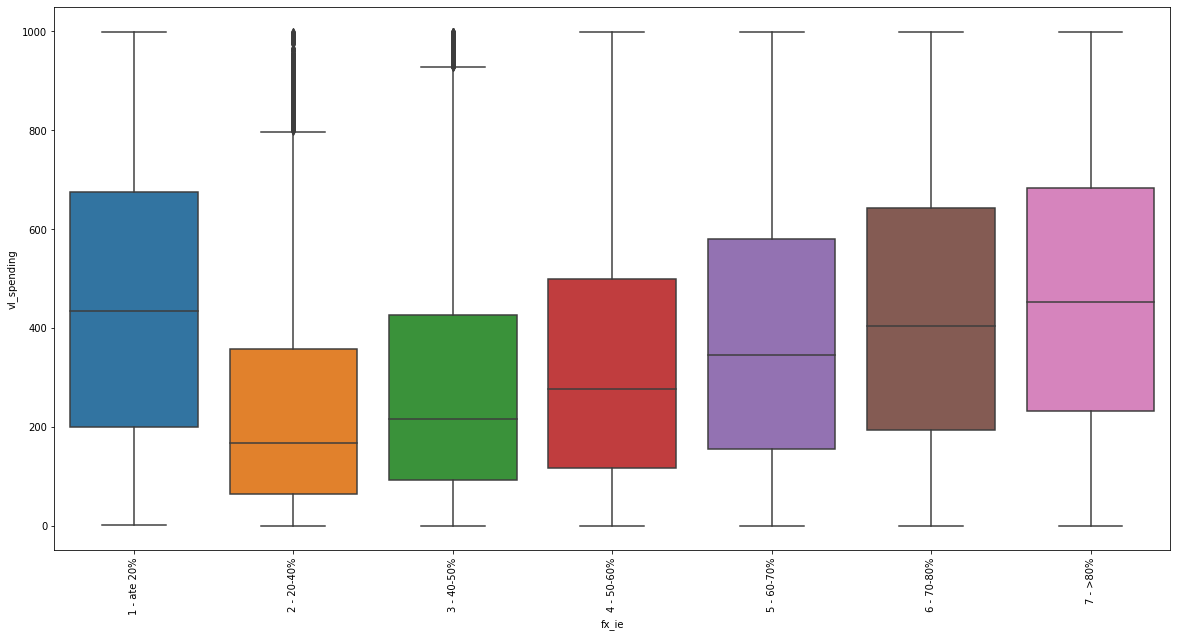

In [42]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_mensal.query('vl_spending < 1000'), y = 'vl_spending', x = 'fx_ie', order=ord_ie) 
plt.xticks(rotation=90)
plt.show()

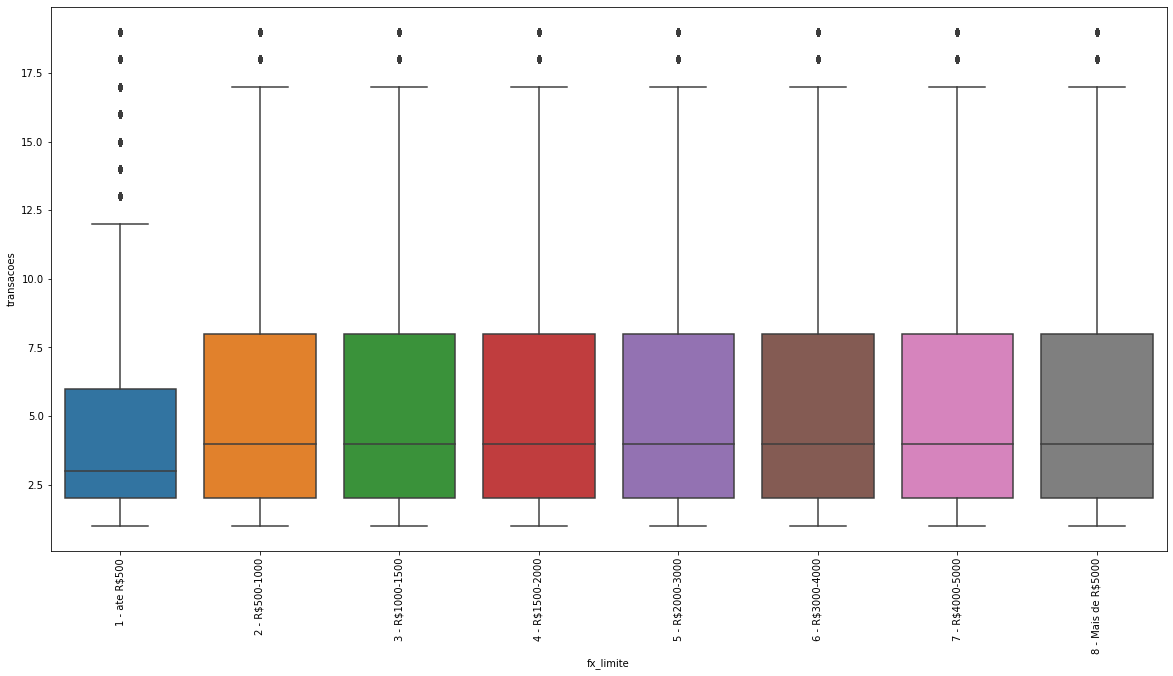

In [44]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_mensal.query('transacoes < 20'), y = 'transacoes', x = 'fx_limite', order=ord_lim) 
plt.xticks(rotation=90)
plt.show()

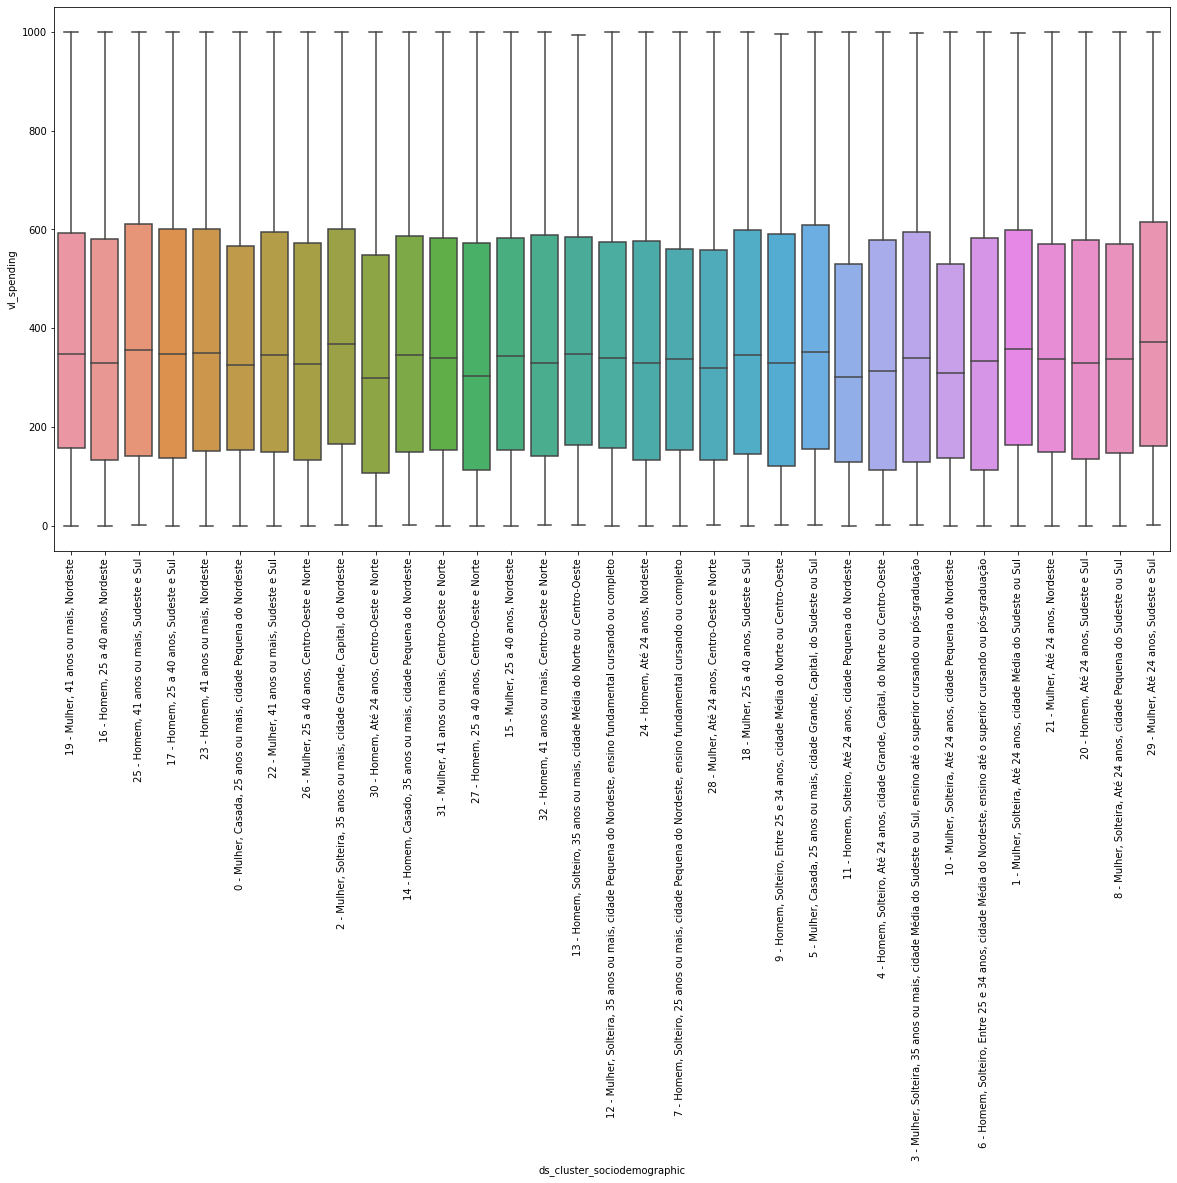

In [45]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_mensal.query('vl_spending < 1000'), y = 'vl_spending', x = 'ds_cluster_sociodemographic') 
plt.xticks(rotation=90)
plt.show()

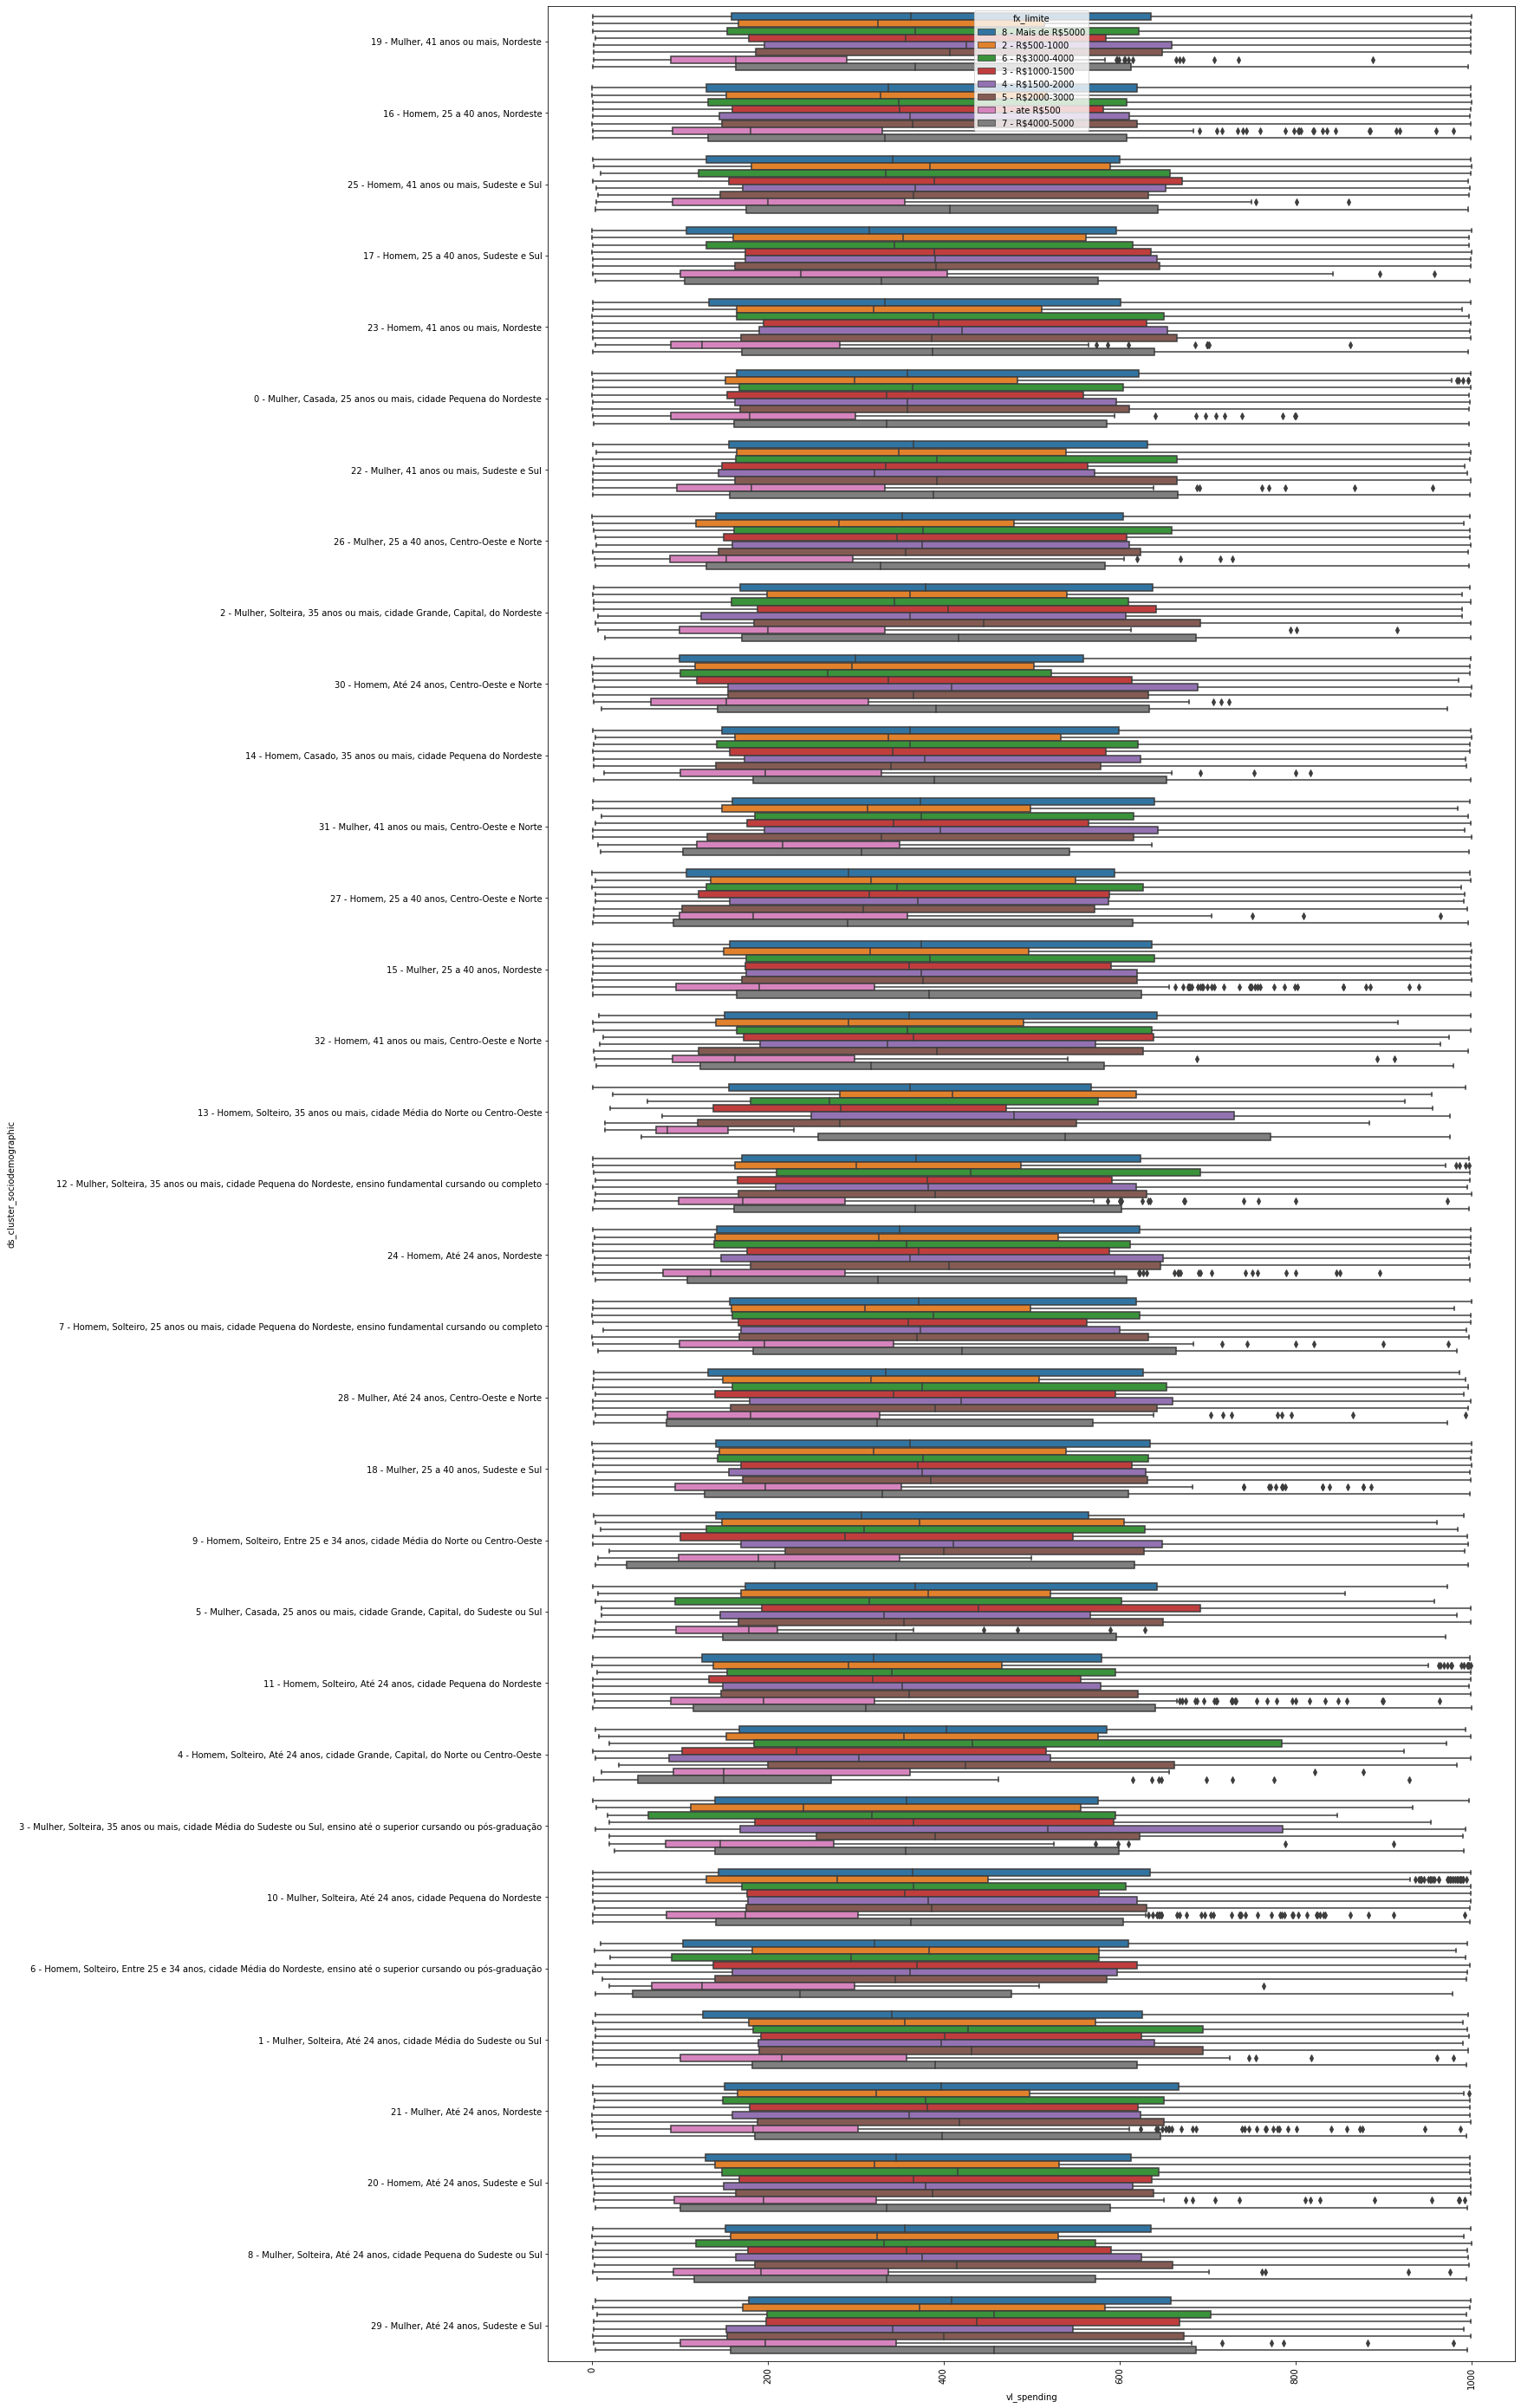

In [46]:
plt.figure(figsize = (20,50))
sns.boxplot(data = df_mensal.query('vl_spending < 1000'), x = 'vl_spending', y = 'ds_cluster_sociodemographic', hue = 'fx_limite') 
plt.xticks(rotation=90)
plt.show()

In [ ]:
query_agg = f"""
with principal as (
	select 
	t.dt_dia
	, t.dt_mes
	, cast(substring(t.dt_dia, 9, 2) as double) as dia_mes
	, cast(substring(t.dt_dia, 1, 4) as double) as ano
	, t.cpf
	, max(t.vl_limite_cartao) as vl_limite_cartao 
	, sum(t.vl_transacao) as vl_spending
	, count(distinct id_autorizacao) as transacoes
	from platform_curated_zone.transaction_dedicada_spending t
	where cast(dt_dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	and cast(dt_dia as date) <= to_date('2023-03-30','yyyy-mm-dd')
	group by 1,2,3,4,5
)
, principal_add as (
select
t.cpf
	, max(c.ds_cluster_sociodemographic) as ds_cluster_sociodemographic 
	, max(ie.nr_score_ie) as nr_score_ie
     
from principal t
	left join customer_curated_zone.ca_book_cliente i on (i.cpf = t.cpf)
	left join customer_curated_zone.ca_book_cliente_cluster c on (c.id_customer = i.id_customer)
	left join customer_curated_zone.ca_model_ie_cliente ie on (ie.cd_cpf = t.cpf and ie.cd_yearmonth = cast(replace(t.dt_mes, '-') as double))
	inner join customer_curated_zone.ca_book_growth g on (g.id_customer = i.id_customer and g.dt_opening_account <= to_date('{dt_query}','yyyy-mm-dd'))
group by 1
)
---------- AGREGANDO --------------
select


select p.* 
, d.ds_cluster_sociodemographic
, d.nr_score_ie
from principal p
left join principal_add d on (p.cpf = d.cpf)

"""